<a href="https://colab.research.google.com/github/VPDeb/Build-Gender-Bias-Insight-App/blob/master/AppModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!pip install eli5
!pip install xgboost
!pip install category_encoders
!pip install shap

     |████████████████████████████████| 327kB 5.5MB/s 
  Created wheel for shap: filename=shap-0.36.0-cp36-cp36m-linux_x86_64.whl size=456467 sha256=a5869ed98d3fe9b30fc0873d73389f9de87c0bde8717a1d76b9f0d9158992d09
  Stored in directory: /root/.cache/pip/wheels/fb/15/e1/8f61106790da27e0765aaa6e664550ca2c50ea339099e799f4
Successfully built shap


## Import of Libraries needed

In [32]:

import pandas as pd
import numpy as np
import shap
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from category_encoders import OrdinalEncoder
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

## Import Datasets

In [33]:
census = pd.read_csv('https://raw.githubusercontent.com/VPDeb/DS-Unit-2-Applied-Modeling/master/Build%20Week%20Project/census.csv')

## Begin EDA

In [34]:
#Time to make the 'missing' values into NaN so we can work with them
census.replace({'?': np.NaN}, inplace=True)

In [35]:
#Printing Top Values to Fill NaNs
print('Top Value:',census['native-country'].describe())
print('Top Value:',census['occupation'].describe())
print('Top Value:',census['workclass'].describe())

Top Value: count             47985
unique               41
top       United-States
freq              43832
Name: native-country, dtype: object
Top Value: count              46033
unique                14
top       Prof-specialty
freq                6172
Name: occupation, dtype: object
Top Value: count       46043
unique          8
top       Private
freq        33906
Name: workclass, dtype: object


In [36]:
#filling NaN values
census['workclass'].replace({np.NaN : 'Private'},inplace=True)
census['occupation'].replace({np.NaN : 'Prof-specialty'}, inplace=True)
census['native-country'].replace({np.NaN : 'United-States'},inplace=True)

#Working on the wrangle function.  Not sure how to get these three def/if/else functions wrapped into one working or multi working function inside of a wranglefunction🤔

In [37]:
#Create a New Feature that changes the income column into a 1 if they make more than 50K a year and 0 if they make 50K or less.  New Feature called 'makes-50K+'.
def over50K(census):
    if census['income'] == '>50K':
        val = 1
    else:
        val = 0
    return val
census['makes-50K+'] = census.apply(over50K, axis=1)

In [38]:
#Create a New Feature that changes the hours worked per week column into a 1 if they worked more than 40 hrs a week and 0 if they worked 40 or less.  New Feature called 'over40hrs'.
def over40(census):
    if census['hours-per-week'] >40:
        val = 1
    else:
        val = 0
    return val
census['over40hrs+'] = census.apply(over40, axis=1)

In [39]:
#Create a New Feature that changes the sex column into a 1 if they were Female and 0 if they were Male.  New Feature called 'gender-F/1-M/0'. This is new Target column.
def gender(census):
    if census['sex'] == 'Female':
            val = 1
    else:
            val = 0
    return val
census['gender-F/1-M/0'] = census.apply(gender, axis=1)

In [40]:
# Time to drop columns we don't need anylonger.  Feature'fnlwgt' is high card and Unnecessary while 'sex' would now become a leaky feature and income and hours per week are now redundant
census = census.drop(columns=['fnlwgt','income','hours-per-week','sex','capital-gain','capital-loss'])

# Splitting the Data

In [41]:
#Split data randomly with a 60/20/20 split

train, val, test = np.split(census.sample(frac=1), [int(.6*len(census)), int(.8*len(census))])

In [42]:
#Split the data into X and y for training the model and making predictions
target= 'gender-F/1-M/0'
y_train = train[target]
X_train = train.drop(target,axis=1)

In [43]:
y_val = val[target]
X_val = val.drop(target,axis=1)

In [44]:
y_test = test[target]
X_test = test.drop(target,axis=1)

# Establishing the Baseline

In [45]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.6679406244668146


# Building the Model

In [46]:
#Starting with a pipeline. Using OrdinalEncoder for the object columns, we do not need and Imputer since they were all filled with top values and I am working with XGBClassifier.
modelxgb = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier(n_jobs=-1)
)
modelxgb.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['workclass', 'education',
                                      'marital-status', 'occupation',
                                      'relationship', 'race',
                                      'native-country'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'workclass',
                                          'data_type': dtype('O'),
                                          'mapping': Private             1
Self-emp-not-inc    2
State-gov           3
Federal-gov         4
Local-gov           5
Self...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta

In [47]:
print('Training accuracy:', modelxgb.score(X_train, y_train))
print('Validation accuracy:', modelxgb.score(X_val, y_val))

Training accuracy: 0.8444975260194506
Validation accuracy: 0.8438779688779688


In [48]:
modelxgb.fit(X_train, y_train)
# make predictions for test data
y_pred = modelxgb.predict(X_test)
# evaluate predictions
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


Accuracy: 84.44%


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


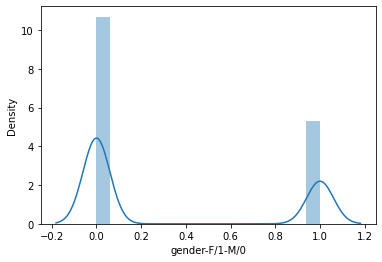

In [49]:
%matplotlib inline
import seaborn as sns
sns.distplot(y_train);

In [51]:
from joblib import dump
dump(modelxgb, 'Pipeline.joblib2', compress=True)

['Pipeline.joblib2']